# Tracking and Economic Nonlinear Model Predictive Control Lecture and Demo

## Illustrative Example

This example is from Lee and Bailey, *Ind. Eng. Chem. Proc. Des. Dev.*, 1980 (re-used in Angeli *et al.*, *IEEE*, 2012).

Consider an isothermal chemical reactor with consecutive-competitive reactions. Specifically, consider two reactions that occur in the reactor:
$$
    \begin{aligned}
        P_0 + B & \to P_1 \\
        P_1 + B & \to P_2
    \end{aligned}
$$
The dimensionless mass balances are:
$$
    \begin{aligned}
        \dot{x}_1 & = u_1 - x_1 - \sigma_1 x_1 x_2 \\
        \dot{x}_2 & = u_2 - x_2 - \sigma_1 x_1 x_2 - \sigma_2 x_2 x_3 \\
        \dot{x}_3 & = -x_3 + \sigma_1 x_1 x_2 - \sigma_2 x_2 x_3 \\
        \dot{x}_4 & = -x_4 + \sigma_2 x_2 x_3
    \end{aligned}
$$

- $x_1$: dimensionless $P_0$ concentration
- $x_2$: dimensionless $B$ concentration
- $x_3$: dimensionless $P_1$ concentration
- $x_4$: dimensionless $P_2$ concentration
- $u_1$: dimensionless inflow rates of $P_0$
- $u_2$: dimensionless inflow rates of $B$
- $\sigma_1$ and $\sigma_2$: rate constants ($\sigma_1 = 1.0$ and $\sigma_2 = 0.4$)

In [1]:
from scipy.optimize import fsolve
from casadi import *
import matplotlib.pyplot as plt

In [2]:
def model(x, u, sigma, xs=None, us=None):
    """Compute the right-hand side of the ODEs
    
    Args:
        x (array-like): State vector
        u (array-like): Input vector
        sigma (array-like): Parameters
        xs (array-like, optional): steady-state
        us (array-like, optional): steady-state input
    
    Returns:
        array-like: dx/dt    
    """
    if xs is not None:
        # Assume x is in deviation variable form
        x = [x[i] + xs[i] for i in range(4)]
        
    if us is not None:
        # Assume u is in deviation variable form
        u = [u[i] + us[i] for i in range(2)]
        
    dxdt = [0.] * 4
    dxdt[0] = u[0] - x[0] - sigma[0] * x[0] * x[1]
    dxdt[1] = u[1] - x[1] - sigma[0] * x[0] * x[1] - sigma[1] * x[1] * x[2]
    dxdt[2] = -x[2] + sigma[0] * x[0] * x[1] - sigma[1] * x[1] * x[2]
    dxdt[3] = -x[3] + sigma[1] * x[1] * x[2]
    return dxdt

In [3]:
# Get the steady-state
us = np.array([1, 2.4310])
sigma = [1.0, 0.4]
f = lambda x: model(x, us, sigma)
xs, _, flag, _ = fsolve(f, [0.4, 1.6, 0.38, 0.24], full_output=True)

print(f'xs = {xs}')
print(f'Exit flag: {flag}')

xs = [0.38743051 1.58110806 0.37524704 0.23732245]
Exit flag: 1


## Tracking Nonlinear Model Predictive Control

Note that $x$ and $u$ are in deviation variable form for the remainder (will need to convert back if we want to present the results in physical variable form).
$$
    \begin{aligned}
        V^*(x) := & \min_{\mathbf{x}, ~\mathbf{u}} && \sum_{k=0}^{N-1} x^T(k)Q x(k) + u^T(k) R u(k) \\
        & \quad\text{s.t.} && x(k+1) = \Phi(x(k), u(k); \bar{f}), & k = 0, \ldots, N-1 \\
        &&& x(0) = x \\
        &&& -u_{s,1} \leq u_1(t) \leq 10 - u_{s,1} \\
        &&& -u_{s,2} \leq u_2(t) \leq 15 - u_{s,2} & t \in [0,T]
    \end{aligned}
$$

Receding horizon principle:

1. At time step $j$, receive $x$ (from sensors or state estimator).
1. Solve the optimal control problem for $\mathbf{u}^* := \{ u^*(0), u^*(1), \ldots, u^*(N-1) \}$.
1. Apply the control command $u^*(0)$ from $j$ to $j + 1$.

In this demonstration, the control actuator and sensor dynamics are  neglected. Also, full state feedback is assumed.

In [4]:
# Parameters (used in optimal control problem later as well)
T = 10.0
N = 100
dt = T/N

In [5]:
# CasADi works with symbolics
t = SX.sym("t", 1, 1)
x = SX.sym("x", 4, 1)
u = SX.sym("u", 2, 1)
ode = vertcat(*model(x, u, sigma, xs=xs, us=us))
print(ode, ode.shape)

@1=(x_0+0.387431), @2=(x_1+1.58111), @3=0.4, @4=(x_2+0.375247), [(((u_0+1)-@1)-(@1*@2)), ((((u_1+2.431)-@2)-(@1*@2))-((@3*@2)*@4)), (((@1*@2)-@4)-((@3*@2)*@4)), (((@3*@2)*@4)-(x_3+0.237322))] (4, 1)


Construct an intergrating block $x_{k+1} = \Phi(f; \Delta t; x_k, u_k)$

In [6]:
f = {'x': x, 't':t, 'p':u , 'ode':ode}
Phi = integrator("Phi", "cvodes", f, {'tf': dt})

In [7]:
# System Model - in general, the system model 
#  and the MPC model are different
system = Phi

## Define Decision Variables and Constraints

Using direct multiple shooting to solve the OCP. Note these do not change from time step to time step

In [8]:
# Define the decision variable and constraints
q = vertcat(*[MX.sym(f'u{i}', 2, 1) for i in range(N)])
s = vertcat(*[MX.sym(f'x{i}', 4, 1) for i in range(N+1)])
# decision variable
z = []
# decision variable, lower and upper bounds
zlb = []
zub = []
constraints = []

# Create a function
cost = 0.
Q = np.eye(4)*3.6
R = np.eye(2)*0.02

# Lower bound and upper bound on input
ulb = list(-us)
uub = list(np.array([10., 15.])-us)

for i in range(N):
    # states
    s_i = s[4*i:4*(i+1)]
    s_ip1 = s[4*(i+1):4*(i+2)]
    # inputs
    q_i = q[2*i:2*(i+1)]
    
    # Decision variable
    zlb += [-np.inf] * 4
    zub += [np.inf] * 4
    zlb += ulb
    zub += uub
    
    z.append(s_i)
    z.append(q_i)
    
    xt_ip1 = Phi(x0=s_i, p=q_i)['xf']
    cost += s_i.T @ Q @ s_i + q_i.T @ R @ q_i
    constraints.append(xt_ip1 - s_ip1)

# s_N
z.append(s_ip1)
zlb += [-np.inf] * 4
zub += [np.inf] * 4

constraints = vertcat(*constraints)
variables = vertcat(*z)

In [9]:
# Create the optmization problem
g_bnd = np.zeros(N*4)
nlp = {'f': cost, 'g': constraints, 'x': variables}
opt = {'print_time': 0, 'ipopt.print_level': 0}
solver = nlpsol('solver', 'ipopt', nlp, opt)

def solve_mpc(current_state):
    """Solve MPC provided the current state, i.e., this 
    function is u = h(x), which is the implicit control law of MPC.
    
    Args:
        current_state (array-like): current state
    
    Returns:
        tuple: current input and return status pair
    """
    
    # Set the lower and upper bound of the decision variable
    # such that s0 = current_state
    for i in range(4):
        zlb[i] = current_state[i]
        zub[i] = current_state[i]
    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_bnd, ubg=g_bnd)
    return np.array(sol_out['x'][4:6]), solver.stats()['return_status']

## Main Simulation Loop

In [10]:
num_time_steps_sim = 20  # number of time steps in simulation

# Store the system states and control actions applied to the system
# in array
state_history = np.zeros((num_time_steps_sim+1, 4))
input_history = np.zeros((num_time_steps_sim+1, 2))

# Set current state - using deviation variables
state_history[0, :] = np.array([0.5, 0.0, 0.7, 0.7]) - xs
current_state = state_history[0, :]

# Time array for plotting
time = [i*dt for i in range(num_time_steps_sim+1)]

# Closed-loop simulation
for k in range(num_time_steps_sim):
    
    print(f'Current time: {k*dt}')
    current_control, status = solve_mpc(current_state)
    print(f'Solver status: {status}')
    
    # Advance the simulation one time step
    # Set current_state to be the state at the next time steps
    current_state = np.array(system(x0=current_state, p=current_control)['xf'])
    
    current_state = current_state.reshape((4,))
    current_control = current_control.reshape((2,))
    
    # Save data for plotting
    input_history[k, :] = current_control
    state_history[k+1:k+2, :] = current_state

# Save the last control one more time for plotting
input_history[-1, :] = current_control

Current time: 0.0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver st

Text(0.5, 0, 'Time')

<Figure size 1008x1008 with 0 Axes>

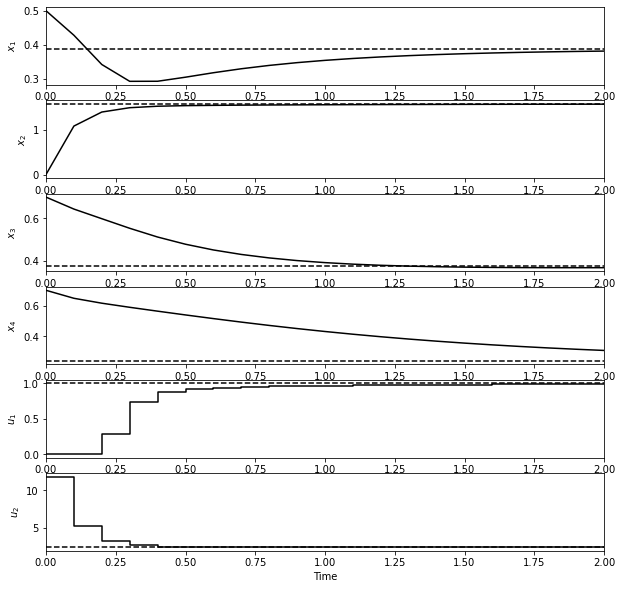

In [11]:
# Figure
plt.figure(figsize=[14, 14])
fig, axs = plt.subplots(6, 1, figsize=[10, 10])
t_max = min(10, num_time_steps_sim*dt)
for j in range(4):
    axs[j].plot(time, state_history[:, j]+xs[j], 'k-', 
                [time[0], time[-1]], [xs[j], xs[j]], 'k--')
    axs[j].set_ylabel(f'$x_{j+1}$')
    axs[j].set_xlim([0, t_max])

for j in range(2):
    axs[j+4].step(time, input_history[:, j]+us[j], 'k-', 
                  [time[0], time[-1]], [us[j], us[j]], 'k--',
                  where='post')
    axs[j+4].set_ylabel(f'$u_{j+1}$')
    axs[j+4].set_xlim([0, t_max])
axs[-1].set_xlabel('Time')

# Economic Model Predictive Control

Relax the assumption that the stage cost $l$ is positive definite with respect to $x = 0$ and $u = 0$.

In this example, we assume that the process economic scales with the concentration of $P_1$ (i.e., want to maximize $x_3$). Equivalently, we can minimize the negative of $x_3$, which is the same as maximizing $x_3$. So, the state cost is:
$$
    l_e(x,u) = -x_3
$$
Additionally, want to constraint the time average value of $u_1$ to be in $[0, 1]$.

See Angeli et al., IEEE TAC, 2012 for more information on the problem.

In [16]:
# Define the decision variable and constraints
q = vertcat(*[MX.sym(f'u{i}', 2, 1) for i in range(N)])
s = vertcat(*[MX.sym(f'x{i}', 4, 1) for i in range(N+1)])
z = []
zlb = []
zub = []
constraints = []
avg_con = 0.

# Create a function
cost = 0.
ulb = list(-us)
uub = list(np.array([10., 15.])-us)

for i in range(N):
    s_i = s[4*i:4*(i+1)]
    s_ip1 = s[4*(i+1):4*(i+2)]
    q_i = q[2*i:2*(i+1)]
    
    # Decision variable
    zlb += [-np.inf] * 4
    zub += [np.inf] * 4
    zlb += ulb
    zub += uub
    
    avg_con += s_i[0]
    
    z.append(s_i)
    z.append(q_i)
    
    xt_ip1 = Phi(x0=s_i, p=q_i)['xf']
    cost += -s_i[2]
    constraints.append(xt_ip1 - s_ip1)

constraints.append(avg_con)
    
# s_N
z.append(s_ip1)
zlb += [0.] * 4
zub += [0.] * 4

constraints = vertcat(*constraints)
variables = vertcat(*z)

In [17]:
# Create the optmization problem
g_lb = np.zeros(N*4+1)
g_ub = np.zeros(N*4+1)
nlp = {'f': cost, 'g': constraints, 'x': variables}
opt = {'print_time': 0, 'ipopt.print_level': 0}
solver = nlpsol('solver', 'ipopt', nlp, opt)

def solve_empc(x, yt_lb, yt_ub):
    """Solve EMPC provided x
    
    Args:
        x (array-like): current state
    
    Returns:
        tuple: current input and return status pair
    """
    for i in range(4):
        zlb[i] = x[i]
        zub[i] = x[i]
    g_lb[-1] = yt_lb
    g_ub[-1] = yt_ub
    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_lb, ubg=g_ub)
    return (np.array(sol_out['x'][4:6]), solver.stats()['return_status'])

In [18]:
Nf = 500
state_history = np.zeros((Nf+1, 4))
input_history = np.zeros((Nf+1, 2))
state_history[0, :] = np.array([0.5, 0.0, 0.7, 0.7]) - xs
xk = state_history[0, :]
time = [i*dt for i in range(Nf+1)]

avg_history = np.zeros((Nf+1, 1))

yi_lb = -N*us[0]-20
yi_ub = N*(1-us[0])+20
y_avg = 0.

# Closed-loop simulation
for k in range(Nf):
    
    print(f'Current time: {k*dt}')
    uk, status = solve_empc(xk, yi_lb, yi_ub)
    print(f'Solver status: {status}')
    xk = np.array(system(x0=xk, p=uk)['xf'])
    
    # Average constraint
    y_avg += uk[0]
    yi_lb += -us[0] - uk[0]
    yi_ub += 1. - us[0] - uk[0]
    avg_history[k, 0] = y_avg / (k+1)
    
    xk = xk.reshape((4,))
    uk = uk.reshape((2,))
    
    input_history[k, :] = uk
    state_history[k+1:k+2, :] = xk

avg_history[Nf, :] = y_avg / (Nf+1)
input_history[Nf, :] = uk

Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver st

Solver status: Solve_Succeeded
Current time: 14.8
Solver status: Solve_Succeeded
Current time: 14.9
Solver status: Solve_Succeeded
Current time: 15.0
Solver status: Solve_Succeeded
Current time: 15.100000000000001
Solver status: Restoration_Failed
Current time: 15.200000000000001
Solver status: Solve_Succeeded
Current time: 15.3
Solver status: Solve_Succeeded
Current time: 15.4
Solver status: Solve_Succeeded
Current time: 15.5
Solver status: Solve_Succeeded
Current time: 15.600000000000001
Solver status: Solve_Succeeded
Current time: 15.700000000000001
Solver status: Solve_Succeeded
Current time: 15.8
Solver status: Solve_Succeeded
Current time: 15.9
Solver status: Infeasible_Problem_Detected
Current time: 16.0
Solver status: Infeasible_Problem_Detected
Current time: 16.1
Solver status: Infeasible_Problem_Detected
Current time: 16.2
Solver status: Infeasible_Problem_Detected
Current time: 16.3
Solver status: Infeasible_Problem_Detected
Current time: 16.400000000000002
Solver status: So

Solver status: Solve_Succeeded
Current time: 29.700000000000003
Solver status: Solve_Succeeded
Current time: 29.8
Solver status: Solve_Succeeded
Current time: 29.900000000000002
Solver status: Infeasible_Problem_Detected
Current time: 30.0
Solver status: Infeasible_Problem_Detected
Current time: 30.1
Solver status: Infeasible_Problem_Detected
Current time: 30.200000000000003
Solver status: Infeasible_Problem_Detected
Current time: 30.3
Solver status: Infeasible_Problem_Detected
Current time: 30.400000000000002
Solver status: Solve_Succeeded
Current time: 30.5
Solver status: Solve_Succeeded
Current time: 30.6
Solver status: Solve_Succeeded
Current time: 30.700000000000003
Solver status: Solve_Succeeded
Current time: 30.8
Solver status: Solve_Succeeded
Current time: 30.900000000000002
Solver status: Solve_Succeeded
Current time: 31.0
Solver status: Solve_Succeeded
Current time: 31.1
Solver status: Solve_Succeeded
Current time: 31.200000000000003
Solver status: Solve_Succeeded
Current tim

Solver status: Infeasible_Problem_Detected
Current time: 44.2
Solver status: Infeasible_Problem_Detected
Current time: 44.300000000000004
Solver status: Infeasible_Problem_Detected
Current time: 44.400000000000006
Solver status: Solve_Succeeded
Current time: 44.5
Solver status: Solve_Succeeded
Current time: 44.6
Solver status: Solve_Succeeded
Current time: 44.7
Solver status: Solve_Succeeded
Current time: 44.800000000000004
Solver status: Solve_Succeeded
Current time: 44.900000000000006
Solver status: Solve_Succeeded
Current time: 45.0
Solver status: Solve_Succeeded
Current time: 45.1
Solver status: Solve_Succeeded
Current time: 45.2
Solver status: Solve_Succeeded
Current time: 45.300000000000004
Solver status: Solve_Succeeded
Current time: 45.400000000000006
Solver status: Solve_Succeeded
Current time: 45.5
Solver status: Solve_Succeeded
Current time: 45.6
Solver status: Solve_Succeeded
Current time: 45.7
Solver status: Solve_Succeeded
Current time: 45.800000000000004
Solver status: S

(0.0, 10.0)

<Figure size 1008x1008 with 0 Axes>

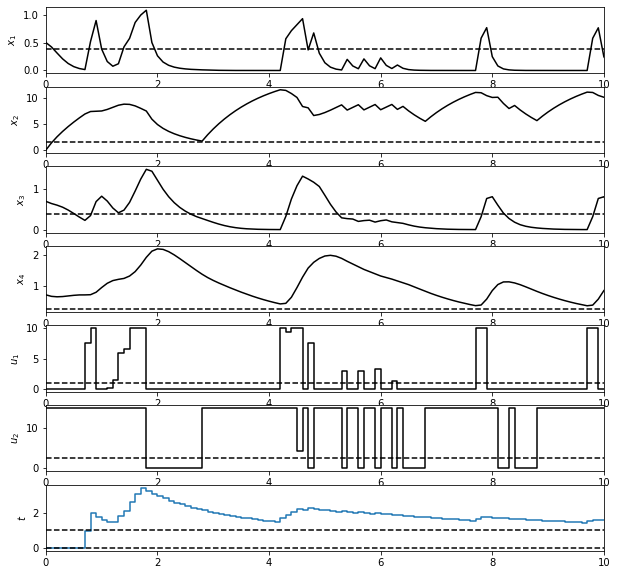

In [19]:
# Figure
plt.figure(figsize=[14, 14])
fig, axs = plt.subplots(7, 1, figsize=[10, 10])
t_max = min(10, Nf*dt)
for j in range(4):
    axs[j].plot(time, state_history[:, j]+xs[j], 'k-', 
                [time[0], time[-1]], [xs[j], xs[j]], 'k--')
    axs[j].set_ylabel(f'$x_{j+1}$')
    axs[j].set_xlim([0, t_max])

for j in range(2):
    axs[j+4].step(time, input_history[:, j]+us[j], 'k-', 
                  [time[0], time[-1]], [us[j], us[j]], 'k--',
                  where='post')
    axs[j+4].set_ylabel(f'$u_{j+1}$')
    axs[j+4].set_xlim([0, t_max])
    
axs[-1].step(time, avg_history+us[0],
             [time[0], time[-1]], [0, 0], 'k--',
             [time[0], time[-1]], [1., 1.], 'k--',
                  where='post')
axs[-1].set_ylabel(f'$y$')
axs[-1].set_ylabel(f'$t$')
axs[-1].set_xlim([0, t_max])